# Modular pipeline demo

In [8]:
import sys
from pathlib import Path

ROOT = Path.cwd().resolve()
if (ROOT / 'src').exists():
    sys.path.insert(0, str(ROOT))
elif (ROOT.parent / 'src').exists():
    
    sys.path.insert(0, str(ROOT.parent))

In [9]:
from src.data.loading import load_movielens_100k, build_ratings_matrix, build_user_folds
from src.eval.metrics import evaluate_all_metrics
from src.models.baselines import global_mean, user_mean, item_mean, random_baseline, popularity_baseline
from src.models.cf import evaluate_user_based_cf, evaluate_item_based_cf
from src.models.mf import evaluate_mf_with_metrics_on_folds
from src.models.svdpp import evaluate_svdpp_with_metrics_on_folds

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, SVDpp, SVD, BaselineOnly, KNNBasic
from surprise.model_selection import cross_validate
import numpy as np

from surprise.model_selection import cross_validate, train_test_split

from cluster_simulation import generate_mask_zipf_global, fill_ratings_clusters

Load data, build the ratings matrix, and create 5-fold splits (hiding 5 ratings per user in test).

In [11]:
ratings_df, users_df, movies_df = load_movielens_100k()
ratings_matrix = build_ratings_matrix(ratings_df)
folds = build_user_folds(ratings_matrix, n_splits=5, test_ratings_per_user=5, random_state=42)
train_df, test_df = folds[0]
train_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Quick baseline comparison on the first fold.

In [5]:
import pandas as pd
R_train, R_test = train_df.values, test_df.values
baselines = [
    ("Global Mean", global_mean(train_df).values),
    ("User Mean", user_mean(train_df).values),
    ("Item Mean", item_mean(train_df).values),
    ("Random [min,max]", random_baseline(train_df).values),
    ("Popularity", popularity_baseline(train_df).values),
]
metrics = []
for name, R_pred in baselines:
    metrics.append({**evaluate_all_metrics(R_train, R_test, R_pred, train_df), "Model": name})
pd.DataFrame(metrics)

,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG@20,Model
0,1.134653,0.957395,4.737617,3.857143,0.594246,0.856854,0.003504,Global Mean
1,1.048662,0.842154,4.737617,3.857143,0.594246,0.856854,0.003504,User Mean
2,1.027383,0.825723,6.962058,4.388889,0.557099,1.000000,0.009034,Item Mean
3,1.794975,1.475437,5.439559,4.000000,0.524678,0.917652,0.008416,"Random [min,max]"
4,1.907282,1.618166,1.384603,3.834758,0.195355,0.459004,0.130457,Popularity


In [6]:
metrics_df = pd.DataFrame(metrics)
ref_rmse = metrics_df.loc[metrics_df['Model'] == 'Global Mean', 'RMSE'].iloc[0]
metrics_df['Relative RMSE'] = metrics_df['RMSE'] / ref_rmse
metrics_df


,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG@20,Model,Relative RMSE
0,1.134653,0.957395,4.737617,3.857143,0.594246,0.856854,0.003504,Global Mean,1.000000
1,1.048662,0.842154,4.737617,3.857143,0.594246,0.856854,0.003504,User Mean,0.924214
2,1.027383,0.825723,6.962058,4.388889,0.557099,1.000000,0.009034,Item Mean,0.905461
3,1.794975,1.475437,5.439559,4.000000,0.524678,0.917652,0.008416,"Random [min,max]",1.581960
4,1.907282,1.618166,1.384603,3.834758,0.195355,0.459004,0.130457,Popularity,1.680940


For full experiments, call the helper evaluators (they mirror the original notebook logic):

In [5]:
# User-based CF (Pearson):
# cf_user_metrics = evaluate_user_based_cf(folds)
# Item-based CF (cosine):
# cf_item_metrics = evaluate_item_based_cf(folds)
# Matrix factorization:
# mf_metrics_df, mf_avg_metrics = evaluate_mf_with_metrics_on_folds(folds)
# SVD++:
# svdpp_metrics_df, svdpp_avg_metrics = evaluate_svdpp_with_metrics_on_folds(folds, n_epochs=5)

Modelo CF basado en usuario

In [5]:
metrics_user_based_cf, avg_user_based_cf = evaluate_user_based_cf(folds)
avg_user_based_cf

,Model,Similarity,k_neighbors,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG@20
0,Memory-based CF,Pearson (user-based),50,0.970477,0.758750,8.362911,4.5,0.995367,0.895830,0.000444
1,Memory-based CF,Pearson (user-based),150,0.966520,0.755765,8.376980,4.5,0.995367,0.895823,0.000444
2,Memory-based CF,Pearson (user-based),500,0.967707,0.757135,8.378482,4.5,0.995367,0.895805,0.000444
3,Memory-based CF,Pearson (user-based),all,0.967710,0.757142,8.378482,4.5,0.995367,0.895805,0.000444


Modelo CF basado en item

In [5]:
metrics_item_based_cf, avg_item_based_cf = evaluate_item_based_cf(folds)
avg_item_based_cf

,Model,Similarity,k_neighbors,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG@20
0,Memory-based CF,Cosine (item-based),50,1.011714,0.789057,7.069925,4.037061,0.476942,0.788108,0.011559
1,Memory-based CF,Cosine (item-based),150,1.020669,0.804161,8.099870,3.980000,0.462853,0.822635,0.003176
2,Memory-based CF,Cosine (item-based),500,1.023725,0.808035,8.434488,5.000000,0.989565,0.830768,0.000106
3,Memory-based CF,Cosine (item-based),all,1.023788,0.808068,8.436024,5.000000,0.989565,0.830768,0.000106


 Modelo descomposición factorial 

In [6]:
mf_metrics_df, mf_avg_metrics = evaluate_mf_with_metrics_on_folds(folds)
mf_avg_metrics

{'RMSE': 0.9399127242684647,
 'MAE': 0.7380416113142835,
 'Novelty': 3.0296218163994184,
 'Relevance': 4.353393399786282,
 'Serendipity': 0.45214069477740626,
 'Diversity': 0.6885421577775552,
 'nDCG@20': 0.05229490371029029}

Modelo SVP++

In [5]:
svdpp_metrics_df, svdpp_avg_metrics = evaluate_svdpp_with_metrics_on_folds(folds, n_epochs=5)
svdpp_avg_metrics

{'RMSE': 0.9594393268351906,
 'MAE': 0.7622817447834908,
 'Novelty': 2.462772160389428,
 'Relevance': 4.17544449114941,
 'Serendipity': 0.3952078101613399,
 'Diversity': 0.5946779668624391,
 'nDCG@20': 0.048667506531036325}

In [12]:
ratings_long = pd.DataFrame(ratings_matrix).stack().reset_index()
ratings_long.columns = ['UserID', 'MovieID', 'Rating']
ratings_long.head()

,UserID,MovieID,Rating
0,1,1,5.0
1,1,2,3.0
2,1,3,4.0
3,1,4,3.0
4,1,5,3.0


In [13]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_long[['UserID', 'MovieID', 'Rating']], reader)
data


In [19]:


# Build Surprise dataset from MovieLens ratings_df
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['UserID', 'MovieID', 'Rating']], reader)

models = {
    'BaselineOnly': BaselineOnly(),
    'KNNBasic': KNNBasic(sim_options={'name': 'pearson_baseline', 'user_based': True}),
    'SVD': SVD(random_state=42),
    'SVDpp': SVDpp(random_state=42),
}

rows = []
for name, algo in models.items():
    cv_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
    rows.append({'Model': name, 'RMSE': float(np.mean(cv_results['test_rmse']))})

metrics_df = pd.DataFrame(rows)
ref_rmse = metrics_df.loc[metrics_df['Model'] == 'BaselineOnly', 'RMSE'].iloc[0]
metrics_df['Relative RMSE'] = metrics_df['RMSE'] / ref_rmse
metrics_df


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,Model,RMSE,Relative RMSE
0,BaselineOnly,0.943894,1.000000
1,KNNBasic,1.000393,1.059858
2,SVD,0.936499,0.992166
3,SVDpp,0.918698,0.973306


C:\Users\mrari\AppData\Local\Temp\ipykernel_20044\3735104141.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='Relative RMSE', palette='tab10')


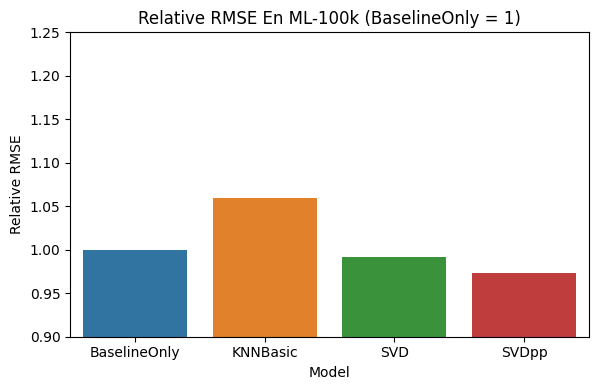

In [22]:
plt.figure(figsize=(6, 4))
sns.barplot(data=metrics_df, x='Model', y='Relative RMSE', palette='tab10')
plt.title('Relative RMSE En ML-100k (BaselineOnly = 1)')
plt.xlabel('Model')
plt.ylabel('Relative RMSE')
plt.tight_layout()
plt.ylim(0.9, 1.25)
plt.show()
